In [1]:
%load_ext autotime

time: 0 ns


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import codecs
import re

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

time: 19.7 s


In [3]:
all_data=[]
prepath = '../nlp_dl_data/'
paths =[r'spam_data/spam', r'spam_data/easy_ham', r'spam_data/hard_ham'] 
paths = [prepath+i for i in paths]

for path in paths:
    for fn in glob.glob(path+"/*"):
        
        if "ham" not in fn:
            is_spam = 1
        else:
            is_spam = 0
        #codecs.open可以避開錯誤，用errors='ignore'
        with codecs.open(fn,encoding='utf-8', errors='ignore') as file:
            for line in file:
                #這個line的開頭為Subject:
                if line.startswith("Subject:"):
                    subject=re.sub(r"^Subject:","",line).strip()
                    all_data.append([subject,is_spam])
all_data = np.array(all_data)

time: 35.9 s


In [4]:
#
all_data

array([['Life Insurance - Why Pay More?', '1'],
       ['[ILUG] Guaranteed to lose 10-12 lbs in 30 days 10.206', '1'],
       ['Guaranteed to lose 10-12 lbs in 30 days                          11.150',
        '1'],
       ...,
       ['NEWS: GNU/DEVELOPMENT... intl orgns take a close look at GNU/Linux',
        '0'],
       ['Attn programmers: support offered [FLOSS-Sarai Initiative]',
        '0'],
       ['(SPAM? 08.00) lists.sourceforge.net mailing list memberships reminder',
        '0']], dtype='<U109')

time: 16 ms


In [5]:
#
all_data[2,0]

'Guaranteed to lose 10-12 lbs in 30 days                          11.150'

time: 266 ms


In [6]:
all_data[2,1]

'1'

time: 31 ms


In [7]:
X = all_data[:,0]
Y = all_data[:,1].astype(np.uint8)

time: 31 ms


In [8]:
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords

import nltk

nltk.download('stopwords')

# Lemmatize with POS Tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

## 創建Lemmatizer
lemmatizer = WordNetLemmatizer() 
def get_wordnet_pos(word):
    """將pos_tag結果mapping到lemmatizer中pos的格式"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def clean_content(X):
    # remove non-alphabet characters
    X_clean = [re.sub('[^a-zA-Z]',' ', x).lower() for x in X]
    # tokenize
    X_word_tokenize = [nltk.word_tokenize(x) for x in X_clean]
    # stopwords_lemmatizer
    X_stopwords_lemmatizer = []
    stop_words = set(stopwords.words('english'))
    for content in X_word_tokenize:
        content_clean = []
        for word in content:
            if word not in stop_words:
                word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                content_clean.append(word)
        X_stopwords_lemmatizer.append(content_clean)
    
    X_output = [' '.join(x) for x in X_stopwords_lemmatizer]
    
    return X_output
                 

time: 1.83 s


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\perry.wei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# befoew clean
X

array(['Life Insurance - Why Pay More?',
       '[ILUG] Guaranteed to lose 10-12 lbs in 30 days 10.206',
       'Guaranteed to lose 10-12 lbs in 30 days                          11.150',
       ...,
       'NEWS: GNU/DEVELOPMENT... intl orgns take a close look at GNU/Linux',
       'Attn programmers: support offered [FLOSS-Sarai Initiative]',
       '(SPAM? 08.00) lists.sourceforge.net mailing list memberships reminder'],
      dtype='<U109')

time: 0 ns


In [24]:
X = clean_content(X)

time: 11.5 s


In [25]:
# after clean X[:3]+
for i in X[:3]+X[-3::1]:
    print(i)

life insurance pay
ilug guaranteed lose lb day
guaranteed lose lb day
news gnu development intl orgns take close look gnu linux
attn programmer support offer floss sarai initiative
spam list sourceforge net mail list membership reminder
time: 0 ns


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
#max_features是要建造幾個column，會按造字出現的頻率高低去篩選，1500並沒有特別含義，大家可以自己嘗試不同數值或不加入限制
cv=CountVectorizer(max_features = 1500)
X=cv.fit_transform(X).toarray()

time: 31 ms


In [27]:
# after CountVectorizer
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

time: 0 ns


In [28]:
from sklearn.model_selection import train_test_split
# random_state是為了讓各為學員得到相同的結果，平時可以移除
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

time: 31 ms


In [29]:
x_train.shape

(2738, 1500)

time: 0 ns


In [30]:
np.unique(y_train)

array([0, 1], dtype=uint8)

time: 0 ns


### 判斷是否有GPU可以使用

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

time: 0 ns


In [32]:
#
device

'cpu'

time: 0 ns


### 模型搭建

In [33]:
class LinearBNAC(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True, dropout=0.3, is_output=False):
        super(LinearBNAC, self).__init__()
        if is_output:
            self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        else:
            self.linear = nn.Sequential(
                nn.Linear(in_channels, out_channels, bias=bias),
                nn.BatchNorm1d(out_channels),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(dropout),
            )
            
    def forward(self, x):
        out=self.linear(x)
        return out

time: 0 ns


In [34]:
class Model(nn.Module):
    def __init__(self, input_dimention, output_classes=1):
        super(Model, self).__init__()
        self.layer1 = LinearBNAC(input_dimention, 16)
        self.layer2 = LinearBNAC(16, 32)
        self.output = LinearBNAC(32, output_classes, is_output=True)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x  
        

time: 0 ns


### 建立模型

* to(device) 代表轉成 cpu or gpu 模式 (gpu 模式下稱為 cuda)

In [40]:
# self: 檢查輸入的維度 => 1500
x_train.shape

(2738, 1500)

time: 0 ns


In [38]:
# self: 檢查輸出的維度 => 1
y_train.shape

(2738,)

time: 0 ns


In [43]:
model = Model(input_dimention=x_train.shape[1],output_classes=2).to(device)  #self : output is 2, not 1

time: 0 ns


In [44]:
for name,_ in model.named_parameters():
    print(name, _.shape)

layer1.linear.0.weight torch.Size([16, 1500])
layer1.linear.0.bias torch.Size([16])
layer1.linear.1.weight torch.Size([16])
layer1.linear.1.bias torch.Size([16])
layer2.linear.0.weight torch.Size([32, 16])
layer2.linear.0.bias torch.Size([32])
layer2.linear.1.weight torch.Size([32])
layer2.linear.1.bias torch.Size([32])
output.linear.weight torch.Size([2, 32])
output.linear.bias torch.Size([2])
time: 0 ns


In [45]:
batch_size = 4
input_features = x_train.shape[1]
dummy_input = torch.randn(batch_size, input_features).to(device)


time: 46 ms


In [190]:
output = model(dummy_input)
print(output)

tensor([[ 0.5925,  0.6819],
        [-1.3743, -0.2197],
        [-0.4221,  0.0343],
        [-0.3071, -0.2330]], grad_fn=<AddmmBackward>)


## Loss

#### classification

In [48]:
from torch.nn import NLLLoss, LogSoftmax, CrossEntropyLoss

time: 0 ns


In [192]:
## CrossEntropyLoss = LogSoftmax + NLLLoss

* CrossEntropyLoss

In [49]:
criterion = CrossEntropyLoss()

time: 0 ns


## optimizer

In [50]:
import torch.optim as optim

time: 0 ns


* params : iterable of parameters
* lr : learning rate
* weight_decay : (L2) Regularization (正則化) 

In [51]:
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

time: 0 ns


### 訓練前準備

In [52]:
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

y_train_numpy = y_train.copy()
y_test_numpy = y_test.copy()

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

time: 15 ms


In [53]:
batch_size = 4
epochs = 50
softmax = nn.Softmax(-1)

index = np.array([x for x in range(len(x_train))])

time: 0 ns


In [54]:
#
index

array([   0,    1,    2, ..., 2735, 2736, 2737])

time: 16 ms


### 訓練

In [55]:
train_loss_ = []
test_loss_ = []
train_accuracy_ = []
test_accuracy_ = []
for epoch in range(epochs):
    
    np.random.shuffle(index)
    x_train = x_train[index]
    y_train = y_train[index]

    loss_keeper = []
    model.train()
    
    for batch in range(len(x_train)//batch_size):
        x = x_train[batch*batch_size : (batch+1)*batch_size,:]
        y = y_train[batch*batch_size : (batch+1)*batch_size]
        output = model(x)
        loss_train = criterion(output, y)
        
        #針對 loss取微分
        loss_train.backward()
        
        #做參數更新
        optimizer.step()
        
        #清空gradient
        optimizer.zero_grad()
        
        loss_train = loss_train.detach().cpu().item()
        loss_keeper.append(loss_train)    
    
    model.eval()
    output = model(x_test)
    prediction = softmax(output)
    prediction = torch.argmax(prediction,1).detach().cpu().numpy()
    test_accuracy = metrics.accuracy_score(prediction, y_test_numpy)
    loss_test = criterion(output, y_test)
    loss_test = loss_test.detach().cpu().item()
    train_loss_.append(np.mean(loss_keeper))
    test_loss_.append(loss_test)
    
    if epoch % 2 == 0:
        print('epoch : {}'.format(epoch))
        print('目前 train loss : {:.2f}'.format(np.mean(loss_keeper)))
        print('目前 test loss : {:.2f}'.format(loss_test))
        print('目前 test accuracy : {:.2f}'.format(test_accuracy))


epoch : 0
目前 train loss : 0.43
目前 test loss : 0.38
目前 test accuracy : 0.86
epoch : 2
目前 train loss : 0.32
目前 test loss : 0.32
目前 test accuracy : 0.91
epoch : 4
目前 train loss : 0.26
目前 test loss : 0.29
目前 test accuracy : 0.90
epoch : 6
目前 train loss : 0.24
目前 test loss : 0.26
目前 test accuracy : 0.91
epoch : 8
目前 train loss : 0.23
目前 test loss : 0.25
目前 test accuracy : 0.92
epoch : 10
目前 train loss : 0.21
目前 test loss : 0.27
目前 test accuracy : 0.87
epoch : 12
目前 train loss : 0.22
目前 test loss : 0.28
目前 test accuracy : 0.89
epoch : 14
目前 train loss : 0.20
目前 test loss : 0.24
目前 test accuracy : 0.90
epoch : 16
目前 train loss : 0.19
目前 test loss : 0.27
目前 test accuracy : 0.89
epoch : 18
目前 train loss : 0.18
目前 test loss : 0.25
目前 test accuracy : 0.91
epoch : 20
目前 train loss : 0.17
目前 test loss : 0.25
目前 test accuracy : 0.90
epoch : 22
目前 train loss : 0.17
目前 test loss : 0.28
目前 test accuracy : 0.89
epoch : 24
目前 train loss : 0.16
目前 test loss : 0.30
目前 test accuracy : 0.89
epoch : 26
目前 tra

In [59]:
print(classification_report(y_test_numpy, prediction))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       587
           1       0.67      0.71      0.69        98

    accuracy                           0.91       685
   macro avg       0.81      0.83      0.82       685
weighted avg       0.91      0.91      0.91       685

time: 0 ns


In [65]:
#
y_test_numpy.sum()

98

time: 0 ns


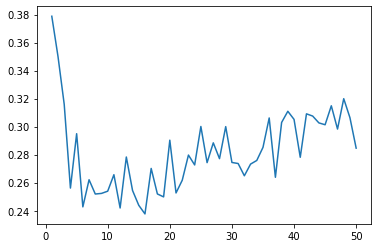

time: 250 ms


In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(test_loss_)+1), test_loss_)
plt.show()

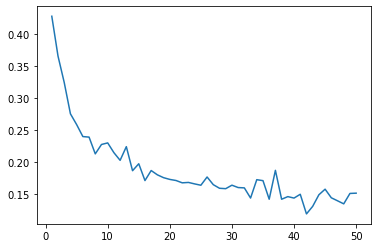

time: 140 ms


In [67]:
#
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(train_loss_)+1), train_loss_)
plt.show()

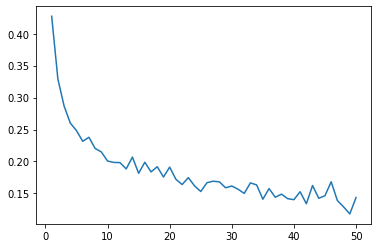

In [201]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(train_loss_)+1), train_loss_)
plt.show()

---

### 儲存跟載入 weight

### 儲存

In [73]:
##假設我們已經訓練好了模型
## 可以存成 .pth or .pt
saving_location = './model_save_exam.pth' # './' 代表目前所屬路徑
torch.save(model.state_dict(), f=saving_location)  #要存成 state_dict，才能使用 load_state_dict

time: 16 ms


### 載入 

In [76]:
from torch.utils import checkpoint

time: 0 ns


In [77]:
model = Model(input_dimention=1500,output_classes=2).to(device)

##載入
checkpoint = torch.load(saving_location, map_location=lambda storage, loc: storage)

model.load_state_dict(checkpoint)

#model.load_state_dict('自行填入')
print('loading successfully...')
print('\n')

model.eval()

test_content = ['Congratulations! You Get a Free Handheld Organizer!']
test_content = clean_content(test_content)
test_content=cv.transform(test_content).toarray()
test_content = torch.tensor(test_content, dtype=torch.float32).to(device)
output = model(test_content)
prediction = softmax(output)
prediction = torch.argmax(prediction,1).detach().cpu().numpy()[0]

if prediction == 1:
    print('Is spam')
else:
    print('Not spam')

loading successfully...


Not spam
time: 16 ms
